# Visual Analytics : Assignment 3 
>#### <font color="#2196F3">Meghna Ramachandra Holla (B00812604) </font>
***

In [700]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn import metrics


In [701]:
# Loading data from CSV file
def load_data():
    path_to_file = "dataset1_processed.csv"
    data_set = pd.read_csv(path_to_file)
    return data_set

In [702]:
def splitData(dataset):
    #gathering numerical values
    datatype_numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numericalValues = dataset.select_dtypes(include=datatype_numeric)
    categoricalValues = dataset.select_dtypes(exclude=datatype_numeric)   
    categoricalValues = categoricalValues.loc[:, categoricalValues.columns != 'salary']
    return (numericalValues, categoricalValues)

In [703]:
def normalizeDataFrame(numericalValues, categoricalValues, data_set):
    
    categorical_df =  pd.get_dummies(categoricalValues, columns=list(categoricalValues.columns))  
    arr = numericalValues.values.astype('float64') 
    min_max_scaler = preprocessing.MinMaxScaler()
    arr_scaled = min_max_scaler.fit_transform(arr)
    numerical_df = pd.DataFrame(arr_scaled)
   
    merged_df=pd.concat([numerical_df,categorical_df],axis=1)

    return merged_df

#https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
#https://stackoverflow.com/questions/39214164/data-conversion-error-while-applying-a-function-to-each-row-in-pandas-python
#https://stackoverflow.com/questions/38413579/what-is-the-difference-between-sklearn-labelencoder-and-pd-get-dummies
#https://www.reddit.com/r/MachineLearning/comments/3nuh7g/is_it_effective_to_use_one_hot_encoding_of/

In [704]:
accuracyArr = []
f1ScoreArr = []
labelsArr = []

In [705]:
def accuracy_f1Score(model, y_pred, y_test):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1Score = metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy Score for",model,"model is", round((accuracy*100),2))
    print("F1 Score for",model,"model is", round((f1Score*100),2))  
    accuracyArr.append((accuracy*100))
    f1ScoreArr.append((f1Score*100))
    labelsArr.append(model)
    print("\n")
    
#https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2

In [706]:
def baggingClassifier(X_train, X_test, y_train, y_test):
    classifier = BaggingClassifier(n_estimators=15)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_f1Score("Bagging", y_pred, y_test)

In [707]:
def randomForestClassifier(X_train, X_test, y_train, y_test):
    classifier = RandomForestClassifier(n_estimators=15)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_f1Score("Random Forest", y_pred, y_test)    

In [708]:
def knnClassifier(X_train, X_test, y_train, y_test):
    classifier = KNeighborsClassifier(n_neighbors=8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) 
    accuracy_f1Score("KNN", y_pred, y_test)        

In [709]:
def classifierComparisonGraph():
    x = np.arange(len(labelsArr))  
    width = 0.15  
    fig, ax = plt.subplots(figsize=[10,5])
    rects1 = ax.bar(x - width/2, f1ScoreArr, width, label='F1 Score',color='#ed5565')
    rects2 = ax.bar(x + width/2, accuracyArr, width, label='Accuracy',color='#f8ac59')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('F1 score and Accuracy Score')
    ax.set_xticks(x)
    ax.set_xticklabels(labelsArr)
    ax.legend(loc='lower right')
    
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

In [710]:
def main():
    
    #Data Load
    data_set = load_data() 

    numericalValues, categoricalValues = splitData(data_set)
    
    feature = normalizeDataFrame(numericalValues, categoricalValues, data_set)
    target = LabelEncoder().fit_transform(data_set['salary'])
    
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=120)
    
    baggingClassifier(X_train, X_test, y_train, y_test)
    randomForestClassifier(X_train, X_test, y_train, y_test)
    knnClassifier(X_train, X_test, y_train, y_test)
    
    classifierComparisonGraph()

Accuracy Score for Bagging model is 82.41
F1 Score for Bagging model is 81.96


Accuracy Score for Random Forest model is 82.15
F1 Score for Random Forest model is 81.61


Accuracy Score for KNN model is 81.92
F1 Score for KNN model is 80.86




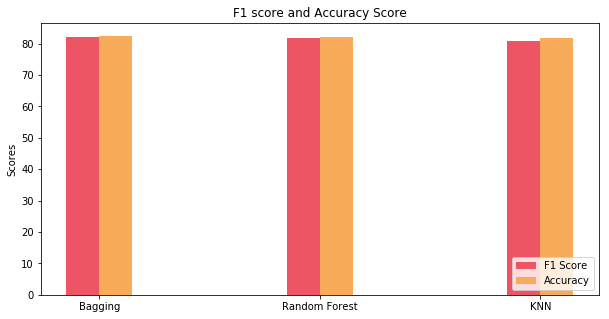

In [711]:
if __name__ == "__main__":
    main()